In [15]:
#librerías, no es necesario volverlas a importar

import pandas as pd
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')



from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import BinaryCrossentropy
from keras.utils import plot_model
from gensim.models import Word2Vec



In [2]:
data_loader = os.path.join('..','0_Data','0_DataLoader.ipynb')
#Vectorizacion
%run $data_loader

[nltk_data] Downloading package punkt to /home/celeste/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/celeste/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/celeste/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, acc, 'r', label='Training acc')
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training accuracy vs loss')
    plt.legend()

In [4]:
def run_model (train_x, train_y, val_x, val_y, test_x, test_y,
               embed_size, max_features, max_len, 
               batch_size, epochs, get_model ):
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_x) + list(val_x))

    train_X = tokenizer.texts_to_sequences(train_x)
    train_X = pad_sequences(train_X, maxlen=max_len)

    val_X = tokenizer.texts_to_sequences(val_x)
    val_X = pad_sequences(val_X, maxlen=max_len)
    
    test_X = tokenizer.texts_to_sequences(test_x)
    test_X = pad_sequences(test_X, maxlen=max_len)

    model = get_model(max_features, embed_size, max_len)


    history = model.fit(train_X, train_y,
                        epochs=epochs,
                        batch_size=batch_size,
                       validation_data=(val_X, val_y),
                       verbose=False)

    #plot_history(history)

    loss, accuracy = model.evaluate(train_X, train_y, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    
    loss, accuracy = model.evaluate(test_X, test_y, verbose=False)
    print("Testing Accuracy: {:.4f}".format(accuracy))
    #test_pred_y = (model.predict(test_X, batch_size=1024, verbose=1) > 0.5).astype("int32")
    #print("Report: \n{}".format(classification_report(test_y, test_pred_y)))
    return model, tokenizer

# 1. Datos Originales

In [5]:
# Se cargan los datos 

data = get_data_original_as_np_array()


## 1.1 Comienzo con red simple con una sola capa conv1d

In [7]:
def get_simple_conv1D(max_features, embed_size, max_len):
    model = Sequential()
    model.add(layers.Embedding(input_dim=max_features, output_dim=embed_size, input_length=max_len))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(max_len, embed_size)))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=49))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation=None))
    model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    return model

In [32]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 70, max_features=12500, max_len = 50,
                            batch_size = 512, epochs=20, get_model = get_simple_conv1D)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 70)            875000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 49, 64)            9024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 49, 64)            0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [33]:
def get_simple_conv1D_4(max_features, embed_size, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embed_size, input_length=max_len))
    model.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(max_len, embed_size)))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=43))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation=None))
    model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    return model

In [36]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 70, max_features=12000, max_len = 50,
                            batch_size = 512, epochs=20, get_model = get_simple_conv1D_4)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 70)            840000    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 43, 64)            35904     
_________________________________________________________________
dropout_22 (Dropout)         (None, 43, 64)            0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                

## 1.2. Aplico convolucion para bigramas y trigramas

In [8]:
def get_ngrams_conv1D(max_features, embed_size, max_len):
    
    embedding_layer = Embedding(input_dim=max_features, output_dim=embed_size, input_length=max_len) 
    
    inputs = Input(shape=(max_len,), dtype='int32')
    
    embedding = embedding_layer(inputs)
    
    conv_0 = Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(max_len, embed_size))(embedding)    
    maxpool_0 = MaxPooling1D(pool_size=4)(conv_0)
    
    conv_1 = Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(max_len, embed_size))(embedding)    
    maxpool_1 = MaxPooling1D(pool_size=4)(conv_1)
    
    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
    
    flatten = Flatten()(concatenated_tensor)
    
    dropout = Dropout(0.5)(flatten)
    
    dense0 = Dense(100, activation='relu')(dropout)
    
    output = Dense(1, activation=None)(dense0)
    
    model = Model(inputs=inputs, outputs=output)

    model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    return model
        

In [80]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 70, max_features=12500, max_len = 50,
                            batch_size = 512, epochs=20, get_model = get_ngrams_conv1D)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 50, 70)       875000      input_18[0][0]                   
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 49, 64)       9024        embedding_28[0][0]               
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 48, 64)       13504       embedding_28[0][0]               
____________________________________________________________________________________________

In [6]:
def get_ngrams_conv1D2(max_features, embed_size, max_len):
    
    embedding_layer = Embedding(input_dim=max_features, output_dim=embed_size, input_length=max_len) 
    
    inputs = Input(shape=(max_len,), dtype='int32')
    
    embedding = embedding_layer(inputs)


    flatten0 = Flatten()(embedding)
    dropout0 = Dropout(0.5)(flatten0)
    dense0 = Dense(100, activation='relu')(dropout0)
    
    conv_1 = Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(max_len, embed_size))(embedding)    
    maxpool_1 = MaxPooling1D(pool_size=max_len-2+1)(conv_1)
    flatten_1 = Flatten()(maxpool_1)
    dropout1 = Dropout(0.5)(flatten_1)
    dense1 = Dense(100, activation='relu')(dropout1)
    
    conv_2 = Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(max_len, embed_size))(embedding)    
    maxpool_2 = MaxPooling1D(pool_size=max_len-3+1)(conv_2)
    flatten_2 = Flatten()(maxpool_2)
    dropout2 = Dropout(0.5)(flatten_2)
    dense2 = Dense(100, activation='relu')(dropout2)
    
    concatenated_tensor = Concatenate(axis=1)([dense0, dense1, dense2])
    
    flatten = Flatten()(concatenated_tensor)
    
    dropout = Dropout(0.5)(flatten)
    
    dense0 = Dense(100, activation='relu')(dropout)
    
    output = Dense(1, activation=None)(dense0)
    
    model = Model(inputs=inputs, outputs=output)

    model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    return model

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 50, 70)       875000      input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 49, 64)       9024        embedding_16[0][0]               
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 48, 64)       13504       embedding_16[0][0]               
____________________________________________________________________________________________

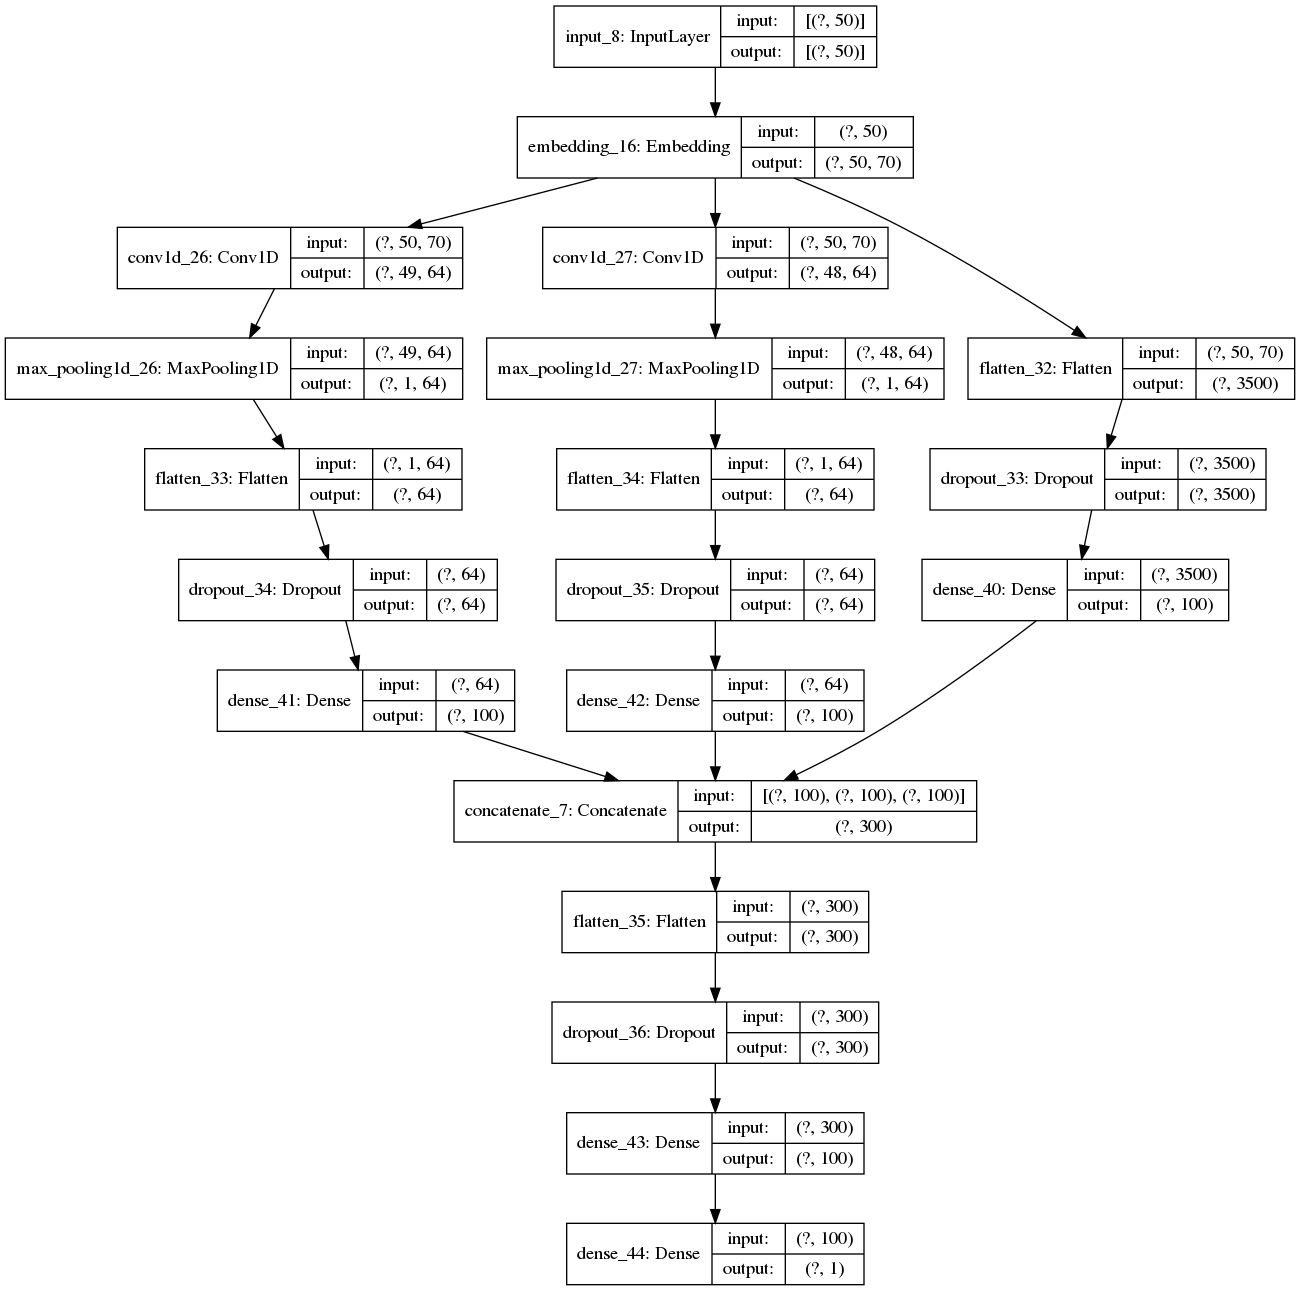

In [44]:
plot_model(get_ngrams_conv1D2(12500,70,50), to_file='CNN_conv1D2.png', show_shapes=True)

In [37]:
model_conv1D2, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 70, max_features=12500, max_len = 50,
                            batch_size = 512, epochs=20, get_model = get_ngrams_conv1D2)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 50, 70)       875000      input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 49, 64)       9024        embedding_13[0][0]               
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 48, 64)       13504       embedding_13[0][0]               
____________________________________________________________________________________________

In [43]:
pred_X = tokenizer.texts_to_sequences(data.predict)
pred_X = pad_sequences(pred_X, maxlen=50)

y_pred = (model_conv1D2.predict(pred_X, batch_size=512, verbose=1) > 0.5).astype("int32")

submission = pd.read_csv(os.path.join('..','0_Data','dataset','sample_submission.csv'))
submission['target'] = y_pred
submission.to_csv("submission_CNN_CONV1D2.csv", index=False)

7/7 [==============================] - 0s 13ms/step


In [38]:
def get_ngrams_conv1D3(max_features, embed_size, max_len):
    
    embedding_layer = Embedding(input_dim=max_features, output_dim=embed_size, input_length=max_len) 
    
    inputs = Input(shape=(max_len,), dtype='int32')
    
    embedding = embedding_layer(inputs)

    #branch 0
    b0 = Conv1D(32, 4, activation='relu')(embedding) 
    b0 = Dropout(0.5)(b0) 
    b0 = MaxPooling1D()(b0) 
    b0 = Flatten()(b0)

    #branch 1    
    b1 = Conv1D(32, 6, activation='relu')(embedding) 
    b1 = Dropout(0.5)(b1) 
    b1 = MaxPooling1D()(b1) 
    b1 = Flatten()(b1) 
    
    #branch 2
    b2 = Conv1D(32, 8, activation='relu')(embedding) 
    b2 = Dropout(0.5)(b2) 
    b2 = MaxPooling1D()(b2) 
    b2 = Flatten()(b2)
    
    merged = Concatenate(axis=1)([b0, b1, b2])
    
    dense = Dense(10, activation='relu')(merged) 
    outputs = Dense(1, activation=None)(dense) 
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    return model

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 50, 70)       875000      input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 47, 32)       8992        embedding_17[0][0]               
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 45, 32)       13472       embedding_17[0][0]               
____________________________________________________________________________________________

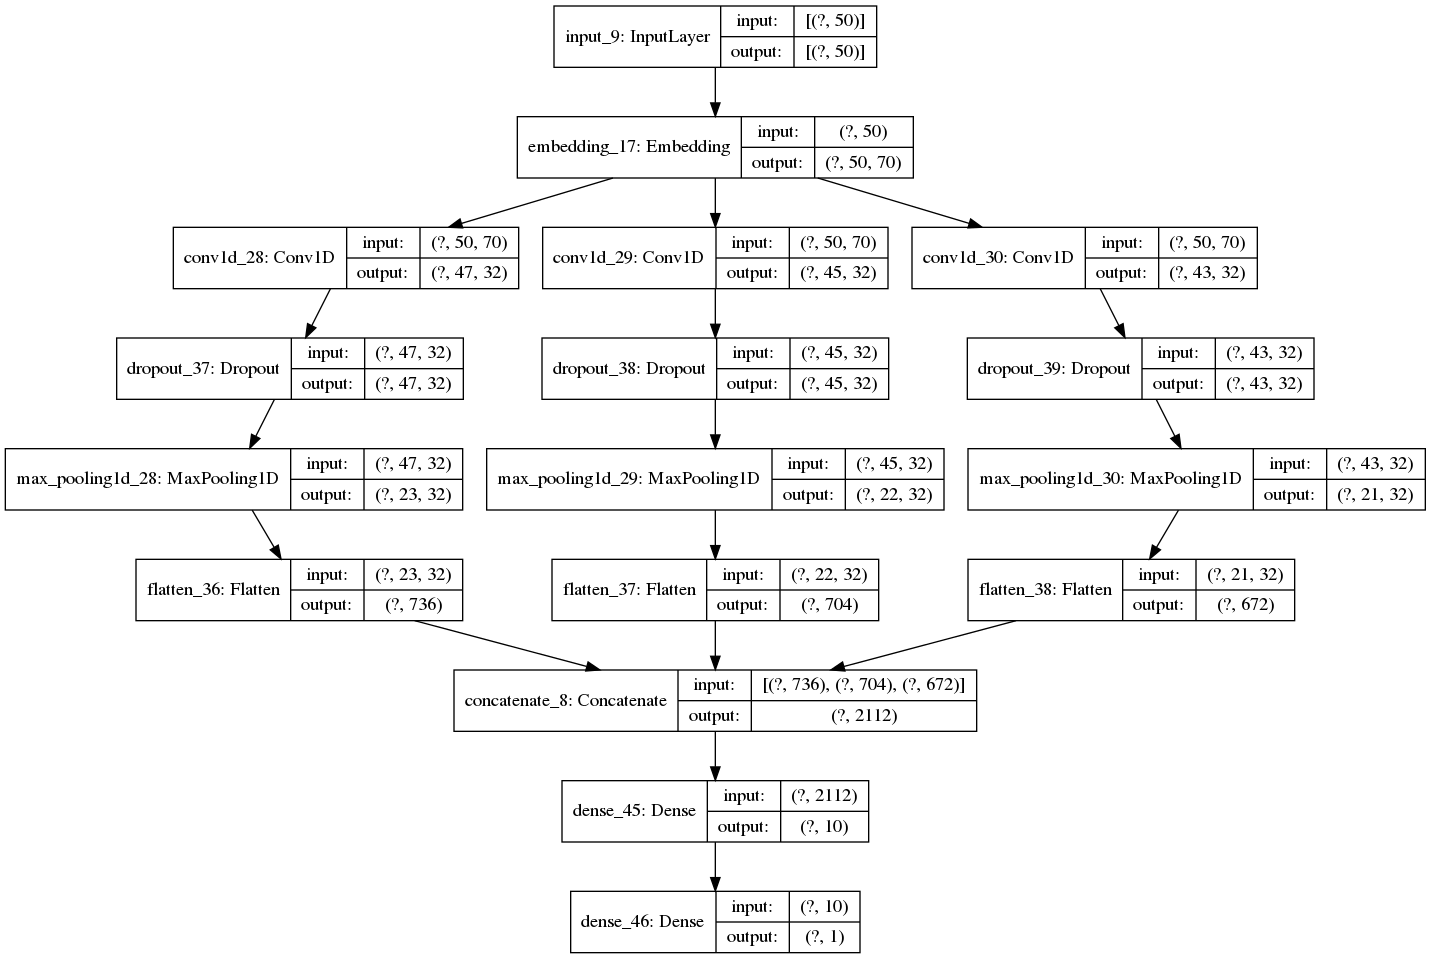

In [45]:
plot_model(get_ngrams_conv1D3(12500,70,50), to_file='CNN_conv1D3.png', show_shapes=True)

In [40]:
model_conv1D3, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 70, max_features=12500, max_len = 50,
                            batch_size = 512, epochs=20, get_model = get_ngrams_conv1D3)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 50, 70)       875000      input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 47, 32)       8992        embedding_15[0][0]               
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 45, 32)       13472       embedding_15[0][0]               
____________________________________________________________________________________________

## 1.3 unigrams + bigrams + trigrams

In [85]:
def get_emb_ngrams_conv1D(max_features, embed_size, max_len):
    
    embedding_layer = Embedding(input_dim=max_features, output_dim=embed_size, input_length=max_len) 
    
    inputs = Input(shape=(max_len,), dtype='int32')
    
    embedding = embedding_layer(inputs)
    
    conv_2 = Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(max_len, embed_size))(embedding)    
    maxpool_2 = MaxPooling1D(pool_size=max_len)(conv_2)
    
    conv_0 = Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(max_len, embed_size))(embedding)    
    maxpool_0 = MaxPooling1D(pool_size=max_len-2+1)(conv_0)
    
    conv_1 = Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(max_len, embed_size))(embedding)    
    maxpool_1 = MaxPooling1D(pool_size=max_len-3+1)(conv_1)
    
    concatenated_tensor = Concatenate(axis=1)([maxpool_2, maxpool_0, maxpool_1])
    
    flatten = Flatten()(concatenated_tensor)
    
    dropout = Dropout(0.5)(flatten)
    
    dense0 = Dense(3, activation='relu')(dropout)
    
    output = Dense(1, activation=None)(dense0)
    
    model = Model(inputs=inputs, outputs=output)

    model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    return model

In [87]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 100, max_features=20000, max_len = 50,
                            batch_size = 512, epochs=20, get_model = get_emb_ngrams_conv1D)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 50, 100)      2000000     input_22[0][0]                   
__________________________________________________________________________________________________
conv1d_44 (Conv1D)              (None, 50, 64)       6464        embedding_32[0][0]               
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 49, 64)       12864       embedding_32[0][0]               
___________________________________________________________________________________________

# 2. Datos Preprocesados

In [76]:
# Se cargan los datos 

data_prep = get_data_sentiment_analysis_as_np_array()


## 2.1  aplico 1 sola capa conv1d


In [72]:
model, tokenizer = run_model(data_prep.x_train,data_prep.y_train, data_prep.x_val, data_prep.y_val, data_prep.x_test, data_prep.y_test,
                             embed_size = 70, max_features=12500, max_len = 50,
                            batch_size = 512, epochs=20, get_model = get_simple_conv1D)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 50, 70)            875000    
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 49, 64)            9024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 49, 64)            0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 1, 64)             0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_27 (Dense)             (None, 1)               

## 2.2  Aplico convolucion para bigramas y trigramas


In [73]:
model, tokenizer = run_model(data_prep.x_train,data_prep.y_train, data_prep.x_val, data_prep.y_val, data_prep.x_test, data_prep.y_test,
                             embed_size = 70, max_features=12500, max_len = 50,
                            batch_size = 512, epochs=20, get_model = get_ngrams_conv1D)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 50, 70)       875000      input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 49, 64)       9024        embedding_26[0][0]               
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 48, 64)       13504       embedding_26[0][0]               
____________________________________________________________________________________________